In [ ]:
%%capture
!pip install gdown
!pip install imutils
!apt-get update && apt-get install -y python3-opencv
!pip install opencv-python
#for kaggle TPU VM
# !pip install /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl

In [4]:
%%capture
import numpy as np
import pandas as pd
import os
import zipfile
from pathlib import Path
import IPython
import cv2
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.image as image
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
import glob
from PIL import Image
from imutils.video import FileVideoStream
import time
import torch
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore", category=FutureWarning)

[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


In [5]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.1


In [7]:
with zipfile.ZipFile("cropped.zip", 'r') as zip_ref:
    zip_ref.extractall('/train')

In [8]:
len(os.listdir('/train'))

119146

In [9]:
train = pd.read_csv('/train.csv')
train.head()

,Unnamed: 0,filename,label
0,0,hrundztjfb.mp4,FAKE
1,1,uyfnfvsxez.mp4,REAL
2,2,yknlciphae.mp4,FAKE
3,3,zfyczzssiz.mp4,FAKE
4,4,kggbciadwj.mp4,REAL


In [ ]:
%%capture
from joblib import Parallel, delayed
# filter out the videos with less than 60 frames
def delfile(f):
        v_cap = FileVideoStream(f).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))
        if v_len < 60:
           os.remove(f)
        v_cap.stop()
files = glob.glob('/train/*.mp4')
Parallel(n_jobs=96)(delayed(delfile)(f) for f in files)

In [11]:
train = train[train['filename'].isin(os.listdir('train'))]

train['path'] = '/train' + train.filename

train_real = train[train['label']=='REAL']
train_fake = train[train['label']=='FAKE']

filenames = list(train_fake.sample(n=20000)['path'].values) + list(train_real['path'].values)

import random
random.shuffle(filenames)

In [12]:
def get_label(filename):
  if 'REAL' in train[train['filename'] == os.path.basename(filename) ]['label'].values:
      return 'REAL'
  else:
      return 'FAKE'

In [13]:
# CHANGED FOR TPU 1VM:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
except tf.errors.NotFoundError:
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  8


In [14]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128,128

IMG_SIZE = (IMAGE_HEIGHT , IMAGE_WIDTH)

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 60

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

data_dir = '/train'
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["REAL","FAKE"]

# Define the number of frames per video
num_frames_per_video = SEQUENCE_LENGTH

# Define the image size
image_size = IMG_SIZE

# Define the number of classes
num_classes = 2

In [15]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [16]:
def frames_from_video_file(video_path, n_frames, output_size = (IMAGE_HEIGHT , IMAGE_WIDTH), frame_step = 1):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [17]:
class FrameGenerator:
  def __init__(self, files, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.files = files
    self.n_frames = n_frames
    self.training = training
    self.class_names = ["REAL","FAKE"]
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = self.files
    classes = [get_label(p) for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [18]:
import random
# Define the train, validation, and test split ratios
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Define the list of video files
video_files = filenames[:20000]

# Shuffle the video files
random.shuffle(video_files)
# Split the video files into train, validation, and test sets
num_videos = len(video_files)
num_train = int(num_videos * train_split)
num_val = int(num_videos * val_split)
num_test = int(num_videos * test_split)

train_files = video_files[:num_train]
val_files = video_files[num_train:num_train+num_val]
test_files = video_files[num_train+num_val:]

In [19]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (60, IMAGE_HEIGHT , IMAGE_WIDTH, 3), dtype = tf.float32),tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_files, 60, training=True),output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_files, 60),output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_files, 60),output_signature = output_signature)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [21]:
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [22]:
train_ds = train_ds.repeat()
val_ds = val_ds.repeat()

In [28]:
with strategy.scope():
    import keras
    from keras.layers import Dense, LSTM, \
        Flatten, TimeDistributed, Conv2D, Dropout,GlobalAveragePooling2D
    from keras import Sequential
    from keras.applications.vgg16 import VGG16
    from keras.applications import EfficientNetB2
    vgg = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )
    ef = EfficientNetB2	(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )
    # do not train first layers, only train
    # the 4 last layers 
    for layer in vgg.layers[:-4]:
        layer.trainable = False
        
        
    # create a Sequential model
    model = Sequential()
    # add vgg model for 5 input images (keeping the right shape
    model.add(TimeDistributed(vgg, input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    
    model.add(LSTM(256, activation='relu', return_sequences=False))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.5))
    
    
    model.add(Dense(2, activation='softmax'))
    model.compile(keras.optimizers.Adam(lr=0.00001), loss='sparse_categorical_crossentropy',metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 60, 4, 4, 512)    14714688  
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 60, 512)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)              

/usr/local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping
STEPS_PER_EPOCH = num_train // BATCH_SIZE
VALIDATION_STEPS = num_val // BATCH_SIZE
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
hist = model.fit(train_ds,validation_data=val_ds,steps_per_epoch = STEPS_PER_EPOCH,validation_steps = VALIDATION_STEPS, epochs=30,callbacks=[es])

In [25]:
model.save('vgg.h5')

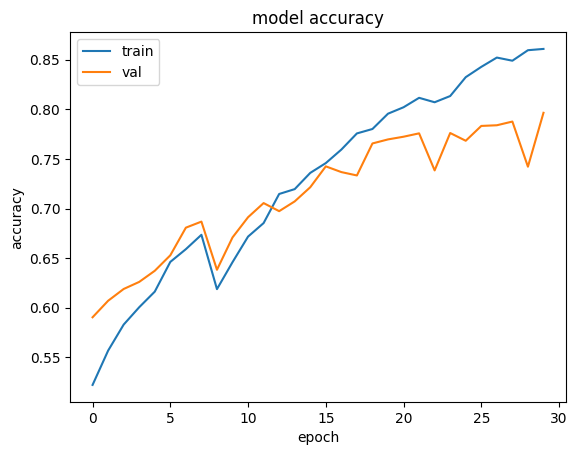

In [26]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

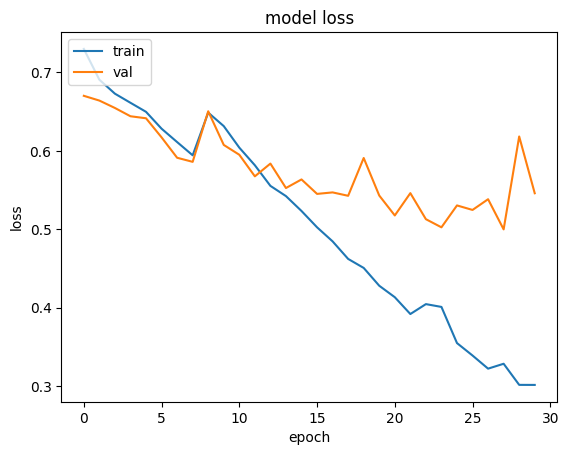

In [27]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [29]:
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_files, SEQUENCE_LENGTH),output_signature = output_signature)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE).batch(BATCH_SIZE)

In [30]:
ModelLoss, ModelAccuracy = model.evaluate(test_ds,steps=num_test//BATCH_SIZE)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

23/23 [==============================] - 604s 25s/step - loss: 0.4696 - accuracy: 0.8122
Test Loss is 0.46958860754966736
Test Accuracy is 0.812160313129425


In [31]:
y_pred = model.predict(test_ds,steps = num_test//BATCH_SIZE)  # store predicted labels

2023-03-24 20:14:08.107362: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-03-24 20:14:08.254282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


23/23 [==============================] - 607s 25s/step


In [32]:
predicted_labels = np.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 6.4 MB/s eta 0:00:0000:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


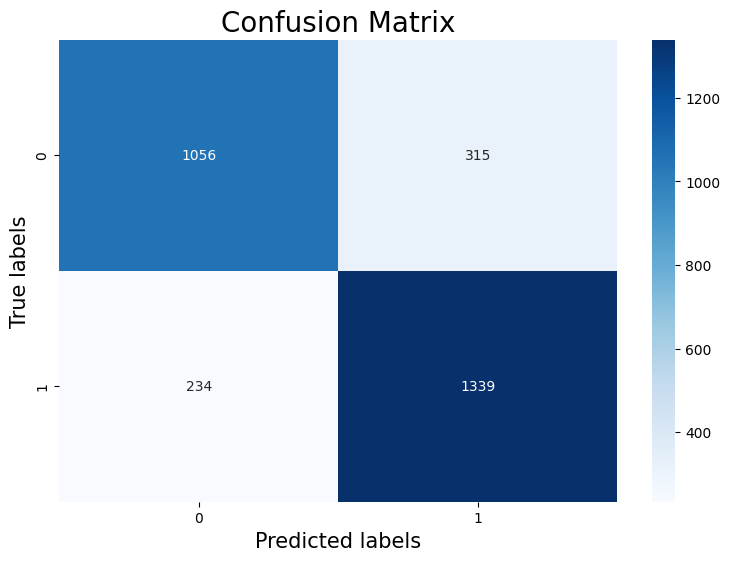

In [35]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(true_categories[:len(predicted_labels)],predicted_labels)
!pip install seaborn
import seaborn as sns
plt.figure(figsize=(9, 6))
ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True,cmap=plt.cm.Blues, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels',size=15);
ax.set_ylabel('True labels',size=15); 
ax.set_title('Confusion Matrix',size=20);